# Hands-on 2 – Edge–Fog–Cloud Deployment: Cost & Footprint Analysis (Student Notebook)

This notebook guides you through the analysis of three deployment architectures (edge-heavy, balanced, cloud-heavy) for a smart-city data analytics pipeline.

Your goals are to:
- Compute energy, economic, CO₂, and social costs for each architecture.
- Compare the architectures using tables and plots.
- Reflect on the trade-offs and social implications of your choice.

## 1. Imports and global parameters

In [ ]:
# TODO: run this cell first
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 5)

# Social cost of carbon in EUR per ton of CO2 (you may experiment with other values)
SOCIAL_COST_PER_TON_CO2 = 100.0

# Workload assumption: number of requests processed per day
REQUESTS_PER_DAY = 1_000_000

print('Parameters set.')

Parameters set.


## 2. Synthetic deployment dataset

The dataset below describes three architectures and their corresponding layers. **Do not worry about the realism of the numbers** – they are chosen to be simple enough for calculations.

Each row is one layer (edge, fog, or cloud) of one architecture.

In [ ]:
# TODO: inspect and understand the dataset
data = [
    # Edge-heavy architecture
    {
        'architecture': 'edge_heavy', 'layer': 'edge',
        'n_devices': 2000, 'power_watts': 5, 'hours_per_day_active': 24,
        'energy_price_eur_per_kwh': 0.18, 'emission_factor_kg_per_kwh': 0.25,
        'capex_eur_per_device': 120, 'lifetime_years': 4,
        'cloud_cost_eur_per_hour': 0.0, 'cloud_hours_per_day': 0.0
    },
    {
        'architecture': 'edge_heavy', 'layer': 'fog',
        'n_devices': 40, 'power_watts': 150, 'hours_per_day_active': 24,
        'energy_price_eur_per_kwh': 0.16, 'emission_factor_kg_per_kwh': 0.30,
        'capex_eur_per_device': 1500, 'lifetime_years': 5,
        'cloud_cost_eur_per_hour': 0.0, 'cloud_hours_per_day': 0.0
    },
    {
        'architecture': 'edge_heavy', 'layer': 'cloud',
        'n_devices': 2, 'power_watts': 250, 'hours_per_day_active': 24,
        'energy_price_eur_per_kwh': 0.14, 'emission_factor_kg_per_kwh': 0.20,
        'capex_eur_per_device': 0, 'lifetime_years': 1,
        'cloud_cost_eur_per_hour': 0.35, 'cloud_hours_per_day': 8
    },

    # Balanced architecture
    {
        'architecture': 'balanced', 'layer': 'edge',
        'n_devices': 1500, 'power_watts': 3, 'hours_per_day_active': 24,
        'energy_price_eur_per_kwh': 0.18, 'emission_factor_kg_per_kwh': 0.25,
        'capex_eur_per_device': 90, 'lifetime_years': 4,
        'cloud_cost_eur_per_hour': 0.0, 'cloud_hours_per_day': 0.0
    },
    {
        'architecture': 'balanced', 'layer': 'fog',
        'n_devices': 80, 'power_watts': 200, 'hours_per_day_active': 24,
        'energy_price_eur_per_kwh': 0.16, 'emission_factor_kg_per_kwh': 0.30,
        'capex_eur_per_device': 2000, 'lifetime_years': 5,
        'cloud_cost_eur_per_hour': 0.0, 'cloud_hours_per_day': 0.0
    },
    {
        'architecture': 'balanced', 'layer': 'cloud',
        'n_devices': 4, 'power_watts': 300, 'hours_per_day_active': 24,
        'energy_price_eur_per_kwh': 0.14, 'emission_factor_kg_per_kwh': 0.20,
        'capex_eur_per_device': 0, 'lifetime_years': 1,
        'cloud_cost_eur_per_hour': 0.35, 'cloud_hours_per_day': 12
    },

    # Cloud-heavy architecture
    {
        'architecture': 'cloud_heavy', 'layer': 'edge',
        'n_devices': 1000, 'power_watts': 1, 'hours_per_day_active': 24,
        'energy_price_eur_per_kwh': 0.18, 'emission_factor_kg_per_kwh': 0.25,
        'capex_eur_per_device': 50, 'lifetime_years': 4,
        'cloud_cost_eur_per_hour': 0.0, 'cloud_hours_per_day': 0.0
    },
    {
        'architecture': 'cloud_heavy', 'layer': 'fog',
        'n_devices': 20, 'power_watts': 100, 'hours_per_day_active': 24,
        'energy_price_eur_per_kwh': 0.16, 'emission_factor_kg_per_kwh': 0.30,
        'capex_eur_per_device': 1200, 'lifetime_years': 5,
        'cloud_cost_eur_per_hour': 0.0, 'cloud_hours_per_day': 0.0
    },
    {
        'architecture': 'cloud_heavy', 'layer': 'cloud',
        'n_devices': 8, 'power_watts': 350, 'hours_per_day_active': 24,
        'energy_price_eur_per_kwh': 0.14, 'emission_factor_kg_per_kwh': 0.20,
        'capex_eur_per_device': 0, 'lifetime_years': 1,
        'cloud_cost_eur_per_hour': 0.40, 'cloud_hours_per_day': 20
    },
]

df = pd.DataFrame(data)
df

,architecture,layer,n_devices,power_watts,hours_per_day_active,energy_price_eur_per_kwh,emission_factor_kg_per_kwh,capex_eur_per_device,lifetime_years,cloud_cost_eur_per_hour,cloud_hours_per_day
0,edge_heavy,edge,2000,5,24,0.18,0.25,120,4,0.00,0.0
1,edge_heavy,fog,40,150,24,0.16,0.30,1500,5,0.00,0.0
2,edge_heavy,cloud,2,250,24,0.14,0.20,0,1,0.35,8.0
3,balanced,edge,1500,3,24,0.18,0.25,90,4,0.00,0.0
4,balanced,fog,80,200,24,0.16,0.30,2000,5,0.00,0.0
5,balanced,cloud,4,300,24,0.14,0.20,0,1,0.35,12.0
6,cloud_heavy,edge,1000,1,24,0.18,0.25,50,4,0.00,0.0
7,cloud_heavy,fog,20,100,24,0.16,0.30,1200,5,0.00,0.0
8,cloud_heavy,cloud,8,350,24,0.14,0.20,0,1,0.40,20.0


👉 **Question:** based on the columns above, which factors do you expect to dominate the cost and footprint of each architecture (number of devices, power, cloud hours, …)? Write a short hypothesis in a markdown cell.

## 3. Row-level derived metrics

Compute for each row:
- `daily_energy_kwh`
- `annual_energy_kwh`
- `annual_energy_cost_eur`
- `annual_emissions_kg`
- `annual_capex_eur`
- `annual_cloud_cost_eur`

Use the formulas from the handout.

In [ ]:
# TODO: add the derived columns to df
df['daily_energy_kwh'] = (
    df['n_devices'] * df['power_watts'] * df['hours_per_day_active'] / 1000.0
)
df['annual_energy_kwh'] = df['daily_energy_kwh'] * 365
df['annual_energy_cost_eur'] = df['annual_energy_kwh'] * df['energy_price_eur_per_kwh']
df['annual_emissions_kg'] = df['annual_energy_kwh'] * df['emission_factor_kg_per_kwh']
df['annual_capex_eur'] = (df['n_devices'] * df['capex_eur_per_device']) / df['lifetime_years']
df['annual_cloud_cost_eur'] = df['cloud_cost_eur_per_hour'] * df['cloud_hours_per_day'] * 365

df[['architecture', 'layer', 'annual_energy_kwh', 'annual_energy_cost_eur', 'annual_emissions_kg']]



,architecture,layer,annual_energy_kwh,annual_energy_cost_eur,annual_emissions_kg
0,edge_heavy,edge,87600.0,15768.00,21900.0
1,edge_heavy,fog,52560.0,8409.60,15768.0
2,edge_heavy,cloud,4380.0,613.20,876.0
3,balanced,edge,39420.0,7095.60,9855.0
4,balanced,fog,140160.0,22425.60,42048.0
5,balanced,cloud,10512.0,1471.68,2102.4
6,cloud_heavy,edge,8760.0,1576.80,2190.0
7,cloud_heavy,fog,17520.0,2803.20,5256.0
8,cloud_heavy,cloud,24528.0,3433.92,4905.6


## 4. Aggregation by architecture

Group by `architecture` and compute totals:
- total annual energy (kWh)
- total annual energy cost (EUR)
- total annual emissions (kg CO₂)
- total annual CAPEX (EUR)
- total annual cloud cost (EUR)
- total annual economic cost (sum of the above monetary components)


In [ ]:
# TODO: aggregate by architecture
agg = df.groupby('architecture').agg(
    total_annual_energy_kwh=('annual_energy_kwh', 'sum'),
    total_annual_energy_cost_eur=('annual_energy_cost_eur', 'sum'),
    total_annual_emissions_kg=('annual_emissions_kg', 'sum'),
    total_annual_capex_eur=('annual_capex_eur', 'sum'),
    total_annual_cloud_cost_eur=('annual_cloud_cost_eur', 'sum')
).reset_index()

agg['total_annual_economic_cost_eur'] = (
    agg['total_annual_energy_cost_eur']
    + agg['total_annual_capex_eur']
    + agg['total_annual_cloud_cost_eur']
)

agg

,architecture,total_annual_energy_kwh,total_annual_energy_cost_eur,total_annual_emissions_kg,total_annual_capex_eur,total_annual_cloud_cost_eur,total_annual_economic_cost_eur
0,balanced,190092.0,30992.88,54005.4,65750.0,1533.0,98275.88
1,cloud_heavy,50808.0,7813.92,12351.6,17300.0,2920.0,28033.92
2,edge_heavy,144540.0,24790.80,38544.0,72000.0,1022.0,97812.80


### 4.1 Social cost of carbon and per-request metrics

Use the global parameters `SOCIAL_COST_PER_TON_CO2` and `REQUESTS_PER_DAY` to compute:
- `social_cost_eur`
- `cost_per_1k_requests_eur`
- `emissions_per_1k_requests_kg`

Remember that 1 ton = 1000 kg.

In [ ]:
# TODO: compute social cost and per-1k-request metrics
requests_per_year = REQUESTS_PER_DAY * 365

agg['social_cost_eur'] = (
    (agg['total_annual_emissions_kg'] / 1000.0) * SOCIAL_COST_PER_TON_CO2
)
agg['cost_per_1k_requests_eur'] = (
    agg['total_annual_economic_cost_eur'] * 1000.0 / requests_per_year
)
agg['emissions_per_1k_requests_kg'] = (
    agg['total_annual_emissions_kg'] * 1000.0 / requests_per_year
)

agg

,architecture,total_annual_energy_kwh,total_annual_energy_cost_eur,total_annual_emissions_kg,total_annual_capex_eur,total_annual_cloud_cost_eur,total_annual_economic_cost_eur,social_cost_eur,cost_per_1k_requests_eur,emissions_per_1k_requests_kg
0,balanced,190092.0,30992.88,54005.4,65750.0,1533.0,98275.88,5400.54,0.269249,0.14796
1,cloud_heavy,50808.0,7813.92,12351.6,17300.0,2920.0,28033.92,1235.16,0.076805,0.03384
2,edge_heavy,144540.0,24790.80,38544.0,72000.0,1022.0,97812.80,3854.40,0.267980,0.10560


## 5. Visual comparison

Create at least one bar chart comparing architectures along two dimensions of your choice, for example:
- total annual economic cost
- total annual CO₂ emissions

Use `matplotlib` bar charts.

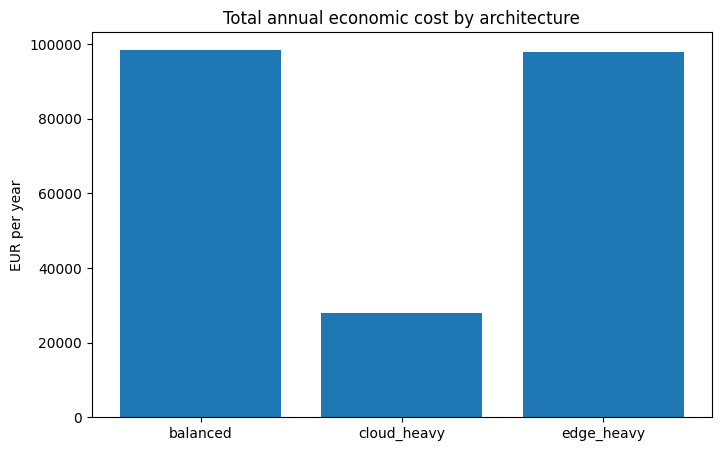

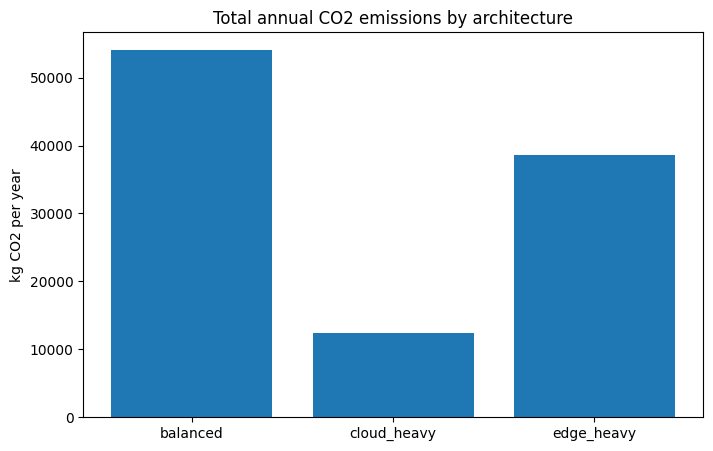

In [ ]:
# TODO: create bar charts for cost and emissions
plt.bar(agg['architecture'], agg['total_annual_economic_cost_eur'])
plt.ylabel('EUR per year')
plt.title('Total annual economic cost by architecture')
plt.show()

plt.bar(agg['architecture'], agg['total_annual_emissions_kg'])
plt.ylabel('kg CO2 per year')
plt.title('Total annual CO2 emissions by architecture')
plt.show()

## 6. Reflection

👉 **Write a short discussion (10–15 lines) addressing the following points:**

- Which architecture is cheapest? Which has the lowest emissions? Are they the same?\
The cloud heavy architecture is the cheapest and has the lowest emissions.


- Is there a good compromise between cost and footprint? Justify your answer.\
There is no real compromise between cost and footprint. The price per 1k requests is almost four times smaller for the cloud heavy architecture compared to the balanced architecture. The emissions in kg per 1k requests are almost five times smaller for the cloud heavy architecture compared to the balanced architecture, and about three times smaller compared to the edge heavy architecture. Therefore, in terms of cost and environmental footprint, the balanced architecture is at a disadvantage compared to the two other architectures. If we only consider cost and footprint, the cloud heavy architecture would be the best choice. However, other parameters such as autonomy and latency also need to be taken into account.

- How would your recommendation change if the social cost of carbon doubled? What if electricity prices increased?\
If the social cost of carbon doubled, architectures with lower emissions would become even more attractive, reinforcing the choice of the cloud heavy architecture. On the other hand, if electricity prices increased, especially in large data centers, the cost advantage of cloud heavy architectures could be reduced, making balanced or edge heavy architectures more competitive.

- Beyond the numbers, how could social factors (local maintenance jobs, data sovereignty, resilience of the system, impact on vulnerable communities) influence the choice of architecture?\
Beyond numerical results, social factors can influence the choice of architecture. If a company values social factors, it may choose an edge heavy or a balanced architecture because it creates local maintenance jobs, improves data sovereignty, and increases system resilience, which can be important for vulnerable communities.